<a href="https://colab.research.google.com/github/alexloaeza12/Simulaci-n-I/blob/main/Inventario_a_entregar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inventario



---



---


## Simulación del Sistema de Inventarios
Este cuaderno de Colab tiene como objetivo implementar una simulación del sistema de inventarios siguiendo el Ejemplo 5.5 del libro de Coss-Bu. Utilizaremos un algoritmo de optimización para encontrar la cantidad óptima a ordenar (q) y el nivel óptimo de reorden (R).

El proceso seguido es el siguiente:
1. Definición de los parámetros y datos necesarios (distribuciones de demanda y tiempo de entrega, factores estacionales, costos y el inventario inicial).
2. Funciones para generar demanda y tiempo de entrega aleatorios.
3. Implementación de la función de simulación del inventario que evalúa el desempeño del sistema durante un año.
4. Definición de una función objetivo para calcular el costo total en función de q y R.
5. Uso de un algoritmo de optimización para encontrar los valores óptimos de q y R.
6. Ejecución de la simulación con los valores óptimos y visualización de los resultados.



---




#Explicación del algoritmo seguido:

1. Definición de Parámetros: Se definen las distribuciones de demanda y tiempo de entrega, así como los costos y el inventario inicial.
2. Generación de Demanda y Tiempo de Entrega: Se crean funciones para generar valores aleatorios basados en las distribuciones de probabilidad definidas.
3. Simulación del Inventario: Se simula el inventario mes a mes, considerando los factores estacionales y registrando los pedidos y costos.
4. Función Objetivo: Se define una función objetivo para calcular el costo total en función de los valores de
𝑞
y
𝑅.
5. Optimización: Se utiliza el algoritmo minimize para encontrar los valores de
𝑞
y
𝑅
que minimizan el costo total.
6. Simulación y Visualización: Finalmente, se ejecuta la simulación con los valores óptimos y se visualizan los resultados.


---



##Parte 1: Importar bibliotecas y definir parámetros

In [25]:
# Primero, importamos las bibliotecas necesarias para la simulación
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Distribución de la demanda mensual
# Definimos la demanda mensual como un diccionario con la cantidad de demanda y su respectiva probabilidad
demanda = {
    35: 0.010, 36: 0.015, 37: 0.020, 38: 0.020, 39: 0.022,
    40: 0.023, 41: 0.025, 42: 0.027, 43: 0.028, 44: 0.029,
    45: 0.035, 46: 0.045, 47: 0.060, 48: 0.065, 49: 0.070,
    50: 0.080, 51: 0.075, 52: 0.070, 53: 0.065, 54: 0.060,
    55: 0.050, 56: 0.040, 57: 0.030, 58: 0.016, 59: 0.015, 60: 0.005
}

# Distribución del tiempo de entrega
# De manera similar, definimos la distribución del tiempo de entrega en meses y su probabilidad
tiempo_entrega = {
    1: 0.30, 2: 0.40, 3: 0.30
}

# Factores estacionales
# Los factores estacionales para cada mes del año que afectan la demanda
factores_estacionales = {
    1: 1.20, 2: 1.00, 3: 0.90, 4: 0.80, 5: 0.80, 6: 0.70,
    7: 0.80, 8: 0.90, 9: 1.00, 10: 1.20, 11: 1.30, 12: 1.40
}

# Costos asociados al inventario
costo_ordenar = 100      # Costo por realizar un pedido
costo_inventario = 20    # Costo por mantener una unidad en inventario por año
costo_faltante = 50      # Costo por unidad faltante

# Inventario inicial
inventario_inicial = 150  # Nivel de inventario inicial


##Parte 2: Funciones para generar demanda y tiempo de entrega

In [26]:
# Definimos funciones para generar demanda y tiempo de entrega según sus distribuciones de probabilidad

def generar_demanda():
    # Genera la demanda basada en la distribución empírica dada
    cantidades = list(demanda.keys())
    probabilidades = list(demanda.values())
    return np.random.choice(cantidades, p=probabilidades)

def generar_tiempo_entrega():
    # Genera el tiempo de entrega basado en la distribución de probabilidad dada
    tiempos = list(tiempo_entrega.keys())
    probabilidades = list(tiempo_entrega.values())
    return np.random.choice(tiempos, p=probabilidades)


##Parte 3: Función para simular el inventario

In [27]:
# La función simular_inventario realiza la simulación del inventario durante un año (12 meses)

def simular_inventario(meses=12, q=200, R=100):
    inventario = inventario_inicial  # Inicializamos el inventario
    costo_total_ordenar = 0
    costo_total_inventario = 0
    costo_total_faltante = 0
    historial_inventario = []
    historial_pedidos = []
    historial_faltantes = []

    pedidos = []  # Lista para rastrear los pedidos pendientes

    for mes in range(1, meses + 1):
        demanda_mes = generar_demanda() * factores_estacionales[mes]  # Generamos la demanda para el mes actual

        # Registrar pedidos si llegan en este mes
        if pedidos:
            for pedido in pedidos.copy():
                if pedido[1] == mes:
                    inventario += pedido[0]
                    pedidos.remove(pedido)

        if inventario < R:
            # Si el inventario cae por debajo del nivel de reorden, hacemos un pedido
            pedido = q
            tiempo_entrega_mes = generar_tiempo_entrega()
            pedidos.append((pedido, mes + tiempo_entrega_mes))  # Agregamos el pedido con el tiempo de entrega
            costo_total_ordenar += costo_ordenar
            historial_pedidos.append((mes, pedido))

        if demanda_mes > inventario:
            # Calculamos los faltantes si la demanda excede el inventario
            faltantes = demanda_mes - inventario
            costo_total_faltante += faltantes * costo_faltante
            inventario = 0
        else:
            faltantes = 0
            inventario -= demanda_mes

        # Calculamos el costo de mantener el inventario
        costo_total_inventario += inventario * costo_inventario / 12
        historial_inventario.append(inventario)
        historial_faltantes.append(faltantes)

    costo_total = costo_total_ordenar + costo_total_inventario + costo_total_faltante

    return historial_inventario, historial_pedidos, historial_faltantes, costo_total


##Parte 4: Función objetivo para la optimización

In [28]:
# Definimos una función objetivo que utilizaremos para encontrar los valores óptimos de q y R

def objetivo(params):
    q, R = params
    _, _, _, costo_total = simular_inventario(q=int(q), R=int(R))
    return costo_total


##Parte 5: Optimización para encontrar los valores óptimos de q y R

In [31]:
# Para encontrar los valores óptimos de q y R, utilizamos un algoritmo de optimización.
# En este caso, utilizamos el método 'L-BFGS-B' que es adecuado para problemas con límites.

# Definimos los límites de búsqueda y las condiciones iniciales
# Los límites aseguran que los valores de q y R estén dentro de un rango razonable.
limites = [(50, 250), (50, 200)]  # Limites para q y R respectivamente
condiciones_iniciales = [100, 100]  # Valores iniciales para q y R

# Ejecutamos la optimización utilizando la función 'minimize' de SciPy
# 'minimize' busca minimizar la función objetivo definida previamente
resultado = minimize(objetivo, condiciones_iniciales, bounds=limites, method='L-BFGS-B')

# Extraemos los valores óptimos de q y R del resultado de la optimización
mejor_q, mejor_R = resultado.x

# Imprimimos los resultados de la optimización
print(f'Cantidad óptima a ordenar (q): {int(mejor_q)}')
print(f'Nivel óptimo de reorden (R): {int(mejor_R)}')
print(f'Costo total mínimo: ${resultado.fun:.2f}')

# Nota: La función 'minimize' ajusta los valores de q y R para minimizar el costo total
# 'L-BFGS-B' es un algoritmo de optimización eficiente que maneja límites en las variables


Cantidad óptima a ordenar (q): 100
Nivel óptimo de reorden (R): 100
Costo total mínimo: $2382.67


##Parte 6: Simulación con los valores óptimos y visualización de resultados

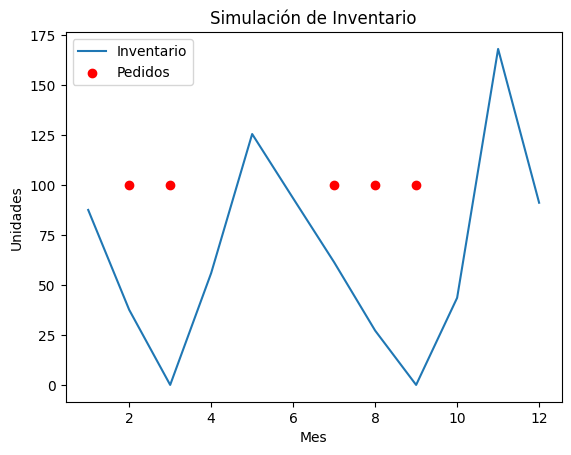

Costo total: $2824.67


In [35]:
# Ejecutamos la simulación con los valores óptimos encontrados
historial_inventario, historial_pedidos, historial_faltantes, costo_total = simular_inventario(q=int(mejor_q), R=int(mejor_R))

# Visualizamos los resultados de la simulación
meses = range(1, 13)
plt.plot(meses, historial_inventario, label='Inventario')
plt.scatter(*zip(*historial_pedidos), color='red', label='Pedidos')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.title('Simulación de Inventario')
plt.legend()
plt.show()

print(f'Costo total: ${costo_total:.2f}')

